In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
# --- Save Model Result Function ---
def save_model_results(model_name, parameters, exog_features, mae, rmse, r2, notes="", csv_path="../../results/model_metrics_log.csv"):
    result = pd.DataFrame([{
        "Model": model_name,
        "Parameters": parameters,
        "Exogenous_Features": exog_features,
        "MAE": mae,
        "RMSE": rmse,
        "R2_Score": r2,
        "Notes": notes
    }])

    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        existing = pd.read_csv(csv_path)
        updated = pd.concat([existing, result], ignore_index=True)
    except FileNotFoundError:
        updated = result

    updated.to_csv(csv_path, index=False)
    print(f"✅ Saved model result to: {csv_path}")

# --- Save Forecast Result Function ---
def save_forecast_results(dates, actual, forecast, model_name, csv_path="../../results/model_forecasts_log.csv"):
    forecast_df = pd.DataFrame({
        "Date": dates,
        "Actual": actual,
        "Forecast": forecast,
        "Model": model_name
    })

    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        existing = pd.read_csv(csv_path)
        updated = pd.concat([existing, forecast_df], ignore_index=True)
    except FileNotFoundError:
        updated = forecast_df

    updated.to_csv(csv_path, index=False)
    print(f"📈 Saved forecast data for {model_name} to: {csv_path}")


In [3]:
# --- Load Data ---
df = pd.read_csv("../../dataset/processed/merged_gold_macro_final_20250331_170349.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Data loaded and sorted:")
print(df.info())


✅ Data loaded and sorted:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2764 non-null   datetime64[ns]
 1   Open                2764 non-null   float64       
 2   High                2764 non-null   float64       
 3   Low                 2764 non-null   float64       
 4   Close               2764 non-null   float64       
 5   Adj_Close           2764 non-null   float64       
 6   Volume              2764 non-null   float64       
 7   USD_Index           2764 non-null   float64       
 8   CPI                 2764 non-null   float64       
 9   Yield_10Y           2764 non-null   float64       
 10  headline_count      2764 non-null   int64         
 11  avg_sentiment       2764 non-null   float64       
 12  std_sentiment       2764 non-null   float64       
 13  gold_return         27

In [4]:
# --- Set Target ---
target_col = "Adj_Close"

# Drop rows with missing target
df_lstm = df.dropna(subset=[target_col]).copy()

# --- Split ---
train_df = df_lstm[df_lstm["Date"] < "2024-01-01"].copy()  # Train: 2012–2023
test_df = df_lstm[df_lstm["Date"] >= "2024-01-01"].copy()  # Test: 2024

print("✅ Train/Test split done:")
print(f"Train: {train_df.shape}, Test: {test_df.shape}")


✅ Train/Test split done:
Train: (2513, 25), Test: (251, 25)


In [5]:
from sklearn.preprocessing import MinMaxScaler

# --- Define a sequence creator function ---
def create_lstm_sequences(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)


In [6]:
# --- Initialize Scaler and Fit on Training Set ---
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[[target_col]])
test_scaled = scaler.transform(test_df[[target_col]])

# --- Set window size ---
window_size = 30

# --- Create sequences from scaled data ---
X_train_lstm, y_train_lstm = create_lstm_sequences(train_scaled, window_size)
X_test_lstm, y_test_lstm = create_lstm_sequences(test_scaled, window_size)

# --- Reshape for LSTM: (samples, timesteps, features) ---
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], window_size, 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], window_size, 1))

print("✅ LSTM sequences prepared:")
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")
print(f"y_test_lstm shape: {y_test_lstm.shape}")


✅ LSTM sequences prepared:
X_train_lstm shape: (2483, 30, 1)
y_train_lstm shape: (2483, 1)
X_test_lstm shape: (221, 30, 1)
y_test_lstm shape: (221, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Define LSTM Model ---
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# --- Build & Train ---
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
lstm_model = build_lstm_model(input_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


2025-04-05 10:46:43.511905: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


63/63 [==============================] - 1s 9ms/step - loss: 0.0167 - val_loss: 0.0013
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 8.4655e-04
Epoch 11/100
63/6

In [8]:
# --- Forecast on test set ---
y_pred_scaled = lstm_model.predict(X_test_lstm)

# --- Inverse transform ---
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# --- Evaluation ---
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n=== LSTM Evaluation on 2024 Test Set ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


7/7 [==============================] - 0s 2ms/step

=== LSTM Evaluation on 2024 Test Set ===
MAE: 47.55
RMSE: 56.95
R² Score: 0.9112


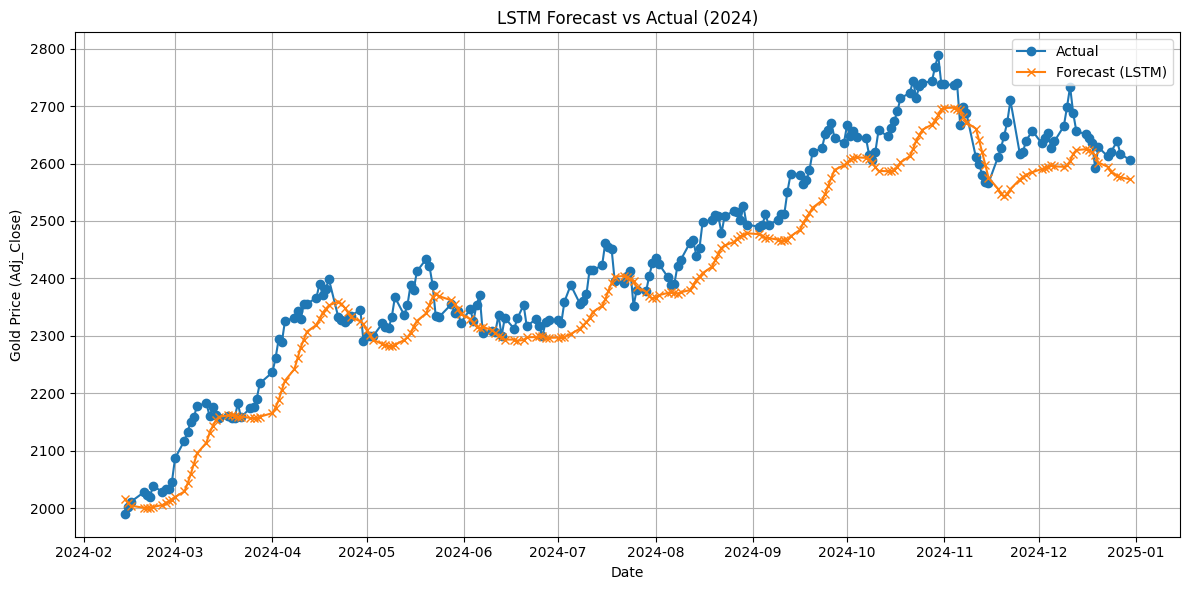

In [9]:
# Create corresponding test dates (drop first 30 for window offset)
test_dates = test_df["Date"].iloc[window_size:].reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true, label="Actual", marker='o')
plt.plot(test_dates, y_pred, label="Forecast (LSTM)", marker='x')
plt.title("LSTM Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [10]:
# Save results
save_model_results(
    model_name="LSTM",
    parameters="units=64, dropout=0.2, optimizer=adam",
    exog_features="Adj_Close only (windowed)",
    mae=mae,
    rmse=rmse,
    r2=r2,
    notes="Univariate LSTM using scaled Adj_Close with window=30"
)

save_forecast_results(
    dates=test_dates,
    actual=y_true.flatten(),
    forecast=y_pred.flatten(),
    model_name="LSTM"
)


✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for LSTM to: ../../results/model_forecasts_log.csv


In [11]:
# --- Select features for multivariate LSTM ---
lstm_features = [
    "Adj_Close",           # target (also used as input)
    "USD_Index",
    "CPI",
    "Yield_10Y",
    "headline_count",
    "avg_sentiment",
    "gold_return"
]


In [12]:
# --- Drop missing values ---
df_lstm_mv = df.dropna(subset=lstm_features).copy()

# --- Split before scaling ---
train_df_mv = df_lstm_mv[df_lstm_mv["Date"] < "2024-01-01"].copy()
test_df_mv = df_lstm_mv[df_lstm_mv["Date"] >= "2024-01-01"].copy()

# --- Initialize and fit scaler on train only ---
mv_scaler = MinMaxScaler()
train_scaled_mv = mv_scaler.fit_transform(train_df_mv[lstm_features])
test_scaled_mv = mv_scaler.transform(test_df_mv[lstm_features])


In [13]:
# --- Create sequences for multivariate input ---
def create_multivariate_sequences(data, target_index=0, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])             # (window, features)
        y.append(data[i+window_size, target_index]) # scalar (target)
    return np.array(X), np.array(y)

# --- Set window size ---
window_size = 30
target_index = 0  # 'Adj_Close' is first in lstm_features list

# --- Create sequences ---
X_train_mv, y_train_mv = create_multivariate_sequences(train_scaled_mv, target_index, window_size)
X_test_mv, y_test_mv = create_multivariate_sequences(test_scaled_mv, target_index, window_size)

print("✅ Multivariate LSTM input prepared:")
print("X_train_mv:", X_train_mv.shape)
print("X_test_mv :", X_test_mv.shape)


✅ Multivariate LSTM input prepared:
X_train_mv: (2483, 30, 7)
X_test_mv : (221, 30, 7)


In [14]:
# --- Build the model ---
input_shape_mv = (X_train_mv.shape[1], X_train_mv.shape[2])

lstm_mv_model = build_lstm_model(input_shape_mv)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train the model ---
history_mv = lstm_mv_model.fit(
    X_train_mv,
    y_train_mv,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
63/63 [==============================] - 1s 9ms/step - loss: 0.0270 - val_loss: 0.0062
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0097
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0086
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0086
Epoch 5/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0110
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0065


In [15]:
# --- Predict on Test Set ---
y_pred_mv_scaled = lstm_mv_model.predict(X_test_mv)

# --- Inverse scale ONLY the Adj_Close (column index 0) ---
# Step 1: Create a temp array with same shape as original test set
pad_array = np.zeros((len(y_pred_mv_scaled), len(lstm_features)))  # shape: (221, 7)
pad_array[:, 0] = y_pred_mv_scaled[:, 0]  # only put predictions in the first column

# Step 2: Inverse transform using scaler
y_pred_mv = mv_scaler.inverse_transform(pad_array)[:, 0]

# Same for actual values
pad_actual = np.zeros((len(y_test_mv), len(lstm_features)))
pad_actual[:, 0] = y_test_mv
y_true_mv = mv_scaler.inverse_transform(pad_actual)[:, 0]

# --- Evaluation ---
mae_mv = mean_absolute_error(y_true_mv, y_pred_mv)
rmse_mv = np.sqrt(mean_squared_error(y_true_mv, y_pred_mv))
r2_mv = r2_score(y_true_mv, y_pred_mv)

print("\n=== Multivariate LSTM Evaluation on 2024 Test Set ===")
print(f"MAE: {mae_mv:.2f}")
print(f"RMSE: {rmse_mv:.2f}")
print(f"R² Score: {r2_mv:.4f}")


7/7 [==============================] - 0s 2ms/step

=== Multivariate LSTM Evaluation on 2024 Test Set ===
MAE: 272.04
RMSE: 281.14
R² Score: -1.1640


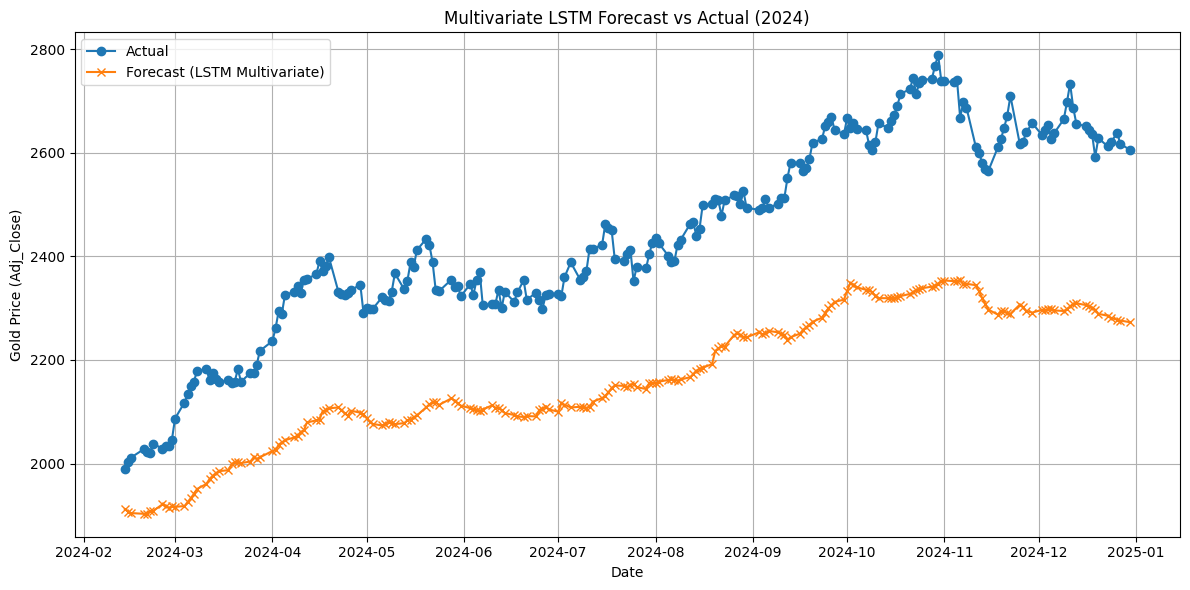

In [16]:
# Create corresponding test dates (drop first 30 for window offset)
test_dates_mv = test_df_mv["Date"].iloc[window_size:].reset_index(drop=True)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(test_dates_mv, y_true_mv, label="Actual", marker='o')
plt.plot(test_dates_mv, y_pred_mv, label="Forecast (LSTM Multivariate)", marker='x')
plt.title("Multivariate LSTM Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# --- Save Results ---
save_model_results(
    model_name="LSTM (Multivariate)",
    parameters="units=64, dropout=0.2, optimizer=adam",
    exog_features=", ".join(lstm_features),
    mae=mae_mv,
    rmse=rmse_mv,
    r2=r2_mv,
    notes="Multivariate LSTM with exogenous inputs, window=30"
)

save_forecast_results(
    dates=test_dates_mv,
    actual=y_true_mv,
    forecast=y_pred_mv,
    model_name="LSTM (Multivariate)"
)

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for LSTM (Multivariate) to: ../../results/model_forecasts_log.csv


In [18]:
# --- Evaluate Feature Strength via Correlation (Train Only) ---
exo_candidates = [
    "USD_Index",
    "CPI",
    "Yield_10Y",
    "headline_count",
    "avg_sentiment",
    "gold_return"
]

# Include target for correlation
corr_df = train_df[["Adj_Close"] + exo_candidates].corr()

# Sort features by absolute correlation with target
correlations = corr_df["Adj_Close"].drop("Adj_Close").abs().sort_values(ascending=False)

print("📊 Correlation with Adj_Close (Train Set):")
print(correlations)


📊 Correlation with Adj_Close (Train Set):
CPI               0.858682
USD_Index         0.342887
headline_count    0.103295
Yield_10Y         0.050389
gold_return       0.033191
avg_sentiment     0.008782
Name: Adj_Close, dtype: float64


In [19]:
lstm_features = [
    "Adj_Close",    # target, always included
    "CPI",
    "USD_Index"
]


In [20]:
# --- Drop missing values ---
df_lstm_mv = df.dropna(subset=lstm_features).copy()

# --- Split before scaling ---
train_df_mv = df_lstm_mv[df_lstm_mv["Date"] < "2024-01-01"].copy()
test_df_mv = df_lstm_mv[df_lstm_mv["Date"] >= "2024-01-01"].copy()

# --- Initialize and fit scaler on train only ---
mv_scaler = MinMaxScaler()
train_scaled_mv = mv_scaler.fit_transform(train_df_mv[lstm_features])
test_scaled_mv = mv_scaler.transform(test_df_mv[lstm_features])

In [21]:
# --- Create sequences for multivariate input ---
def create_multivariate_sequences(data, target_index=0, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])             # (window, features)
        y.append(data[i+window_size, target_index]) # scalar (target)
    return np.array(X), np.array(y)

# --- Set window size ---
window_size = 30
target_index = 0  # 'Adj_Close' is the first column

# --- Create sequences ---
X_train_mv, y_train_mv = create_multivariate_sequences(train_scaled_mv, target_index, window_size)
X_test_mv, y_test_mv = create_multivariate_sequences(test_scaled_mv, target_index, window_size)


In [22]:
print("✅ Semi-Multivariate LSTM input prepared:")
print("X_train_mv:", X_train_mv.shape)
print("X_test_mv :", X_test_mv.shape)


✅ Semi-Multivariate LSTM input prepared:
X_train_mv: (2483, 30, 3)
X_test_mv : (221, 30, 3)


In [23]:
# --- Build the model ---
input_shape_mv = (X_train_mv.shape[1], X_train_mv.shape[2])

lstm_mv_model = build_lstm_model(input_shape_mv)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train the model ---
history_mv = lstm_mv_model.fit(
    X_train_mv,
    y_train_mv,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
63/63 [==============================] - 1s 9ms/step - loss: 0.0126 - val_loss: 0.0014
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 9.7123e-04
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 8.5928e-04
E

In [24]:
# --- Predict on Test Set ---
y_pred_mv_scaled = lstm_mv_model.predict(X_test_mv)

# --- Inverse scale ONLY the Adj_Close (column index 0) ---
pad_array = np.zeros((len(y_pred_mv_scaled), len(lstm_features)))
pad_array[:, 0] = y_pred_mv_scaled[:, 0]
y_pred_mv = mv_scaler.inverse_transform(pad_array)[:, 0]

pad_actual = np.zeros((len(y_test_mv), len(lstm_features)))
pad_actual[:, 0] = y_test_mv
y_true_mv = mv_scaler.inverse_transform(pad_actual)[:, 0]

# --- Evaluation ---
mae_mv = mean_absolute_error(y_true_mv, y_pred_mv)
rmse_mv = np.sqrt(mean_squared_error(y_true_mv, y_pred_mv))
r2_mv = r2_score(y_true_mv, y_pred_mv)

print("\n=== Semi-Multivariate LSTM Evaluation on 2024 Test Set ===")
print(f"MAE: {mae_mv:.2f}")
print(f"RMSE: {rmse_mv:.2f}")
print(f"R² Score: {r2_mv:.4f}")


7/7 [==============================] - 0s 2ms/step

=== Semi-Multivariate LSTM Evaluation on 2024 Test Set ===
MAE: 27.75
RMSE: 34.71
R² Score: 0.9670


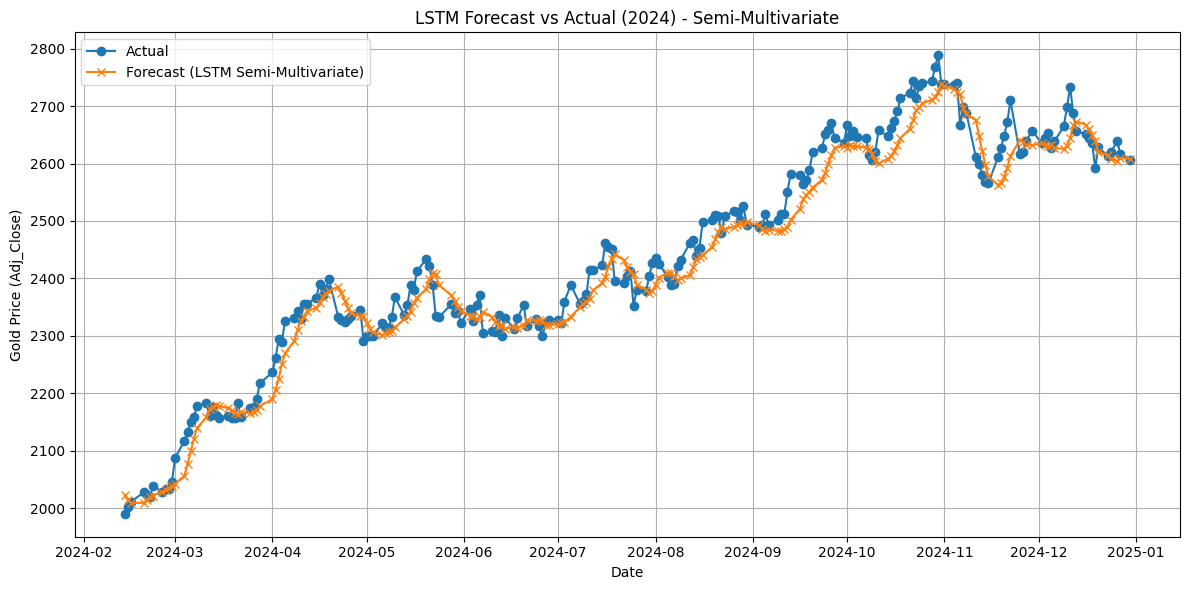

In [25]:
# Create corresponding test dates (drop first 30 for window offset)
test_dates_mv = test_df_mv["Date"].iloc[window_size:].reset_index(drop=True)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(test_dates_mv, y_true_mv, label="Actual", marker='o')
plt.plot(test_dates_mv, y_pred_mv, label="Forecast (LSTM Semi-Multivariate)", marker='x')
plt.title("LSTM Forecast vs Actual (2024) - Semi-Multivariate")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# --- Save Results ---
save_model_results(
    model_name="LSTM (Semi-Multivariate)",
    parameters="units=64, dropout=0.2, optimizer=adam",
    exog_features=", ".join(lstm_features),
    mae=mae_mv,
    rmse=rmse_mv,
    r2=r2_mv,
    notes="Semi-Multivariate LSTM using CPI and USD_Index, window=30"
)


✅ Saved model result to: ../../results/model_metrics_log.csv


In [27]:
save_forecast_results(
    dates=test_dates_mv,
    actual=y_true_mv,
    forecast=y_pred_mv,
    model_name="LSTM (Semi-Multivariate)"
)

📈 Saved forecast data for LSTM (Semi-Multivariate) to: ../../results/model_forecasts_log.csv
